# Jit

In [1]:
import numpy as np
from pylab import imshow, show
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import cProfile

# Task 14. Jitted Mandelbrot set

## Original

In [2]:
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i
    return max_iters

In [3]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

Mandelbrot created in 4.902190 s


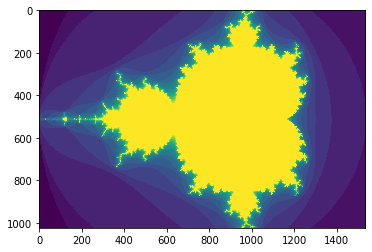

In [4]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = time()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = time() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

In [5]:
cProfile.run('create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)')

         1572868 function calls in 5.286 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1572864    4.704    0.000    4.704    0.000 <ipython-input-2-6b3dbb8be62b>:1(mandel)
        1    0.582    0.582    5.286    5.286 <ipython-input-3-20ba7ba068fe>:1(create_fractal)
        1    0.000    0.000    5.286    5.286 <string>:1(<module>)
        1    0.000    0.000    5.286    5.286 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [6]:
number_of_iter = [20, 100, 200, 1000, 2000]
image = np.zeros((1024, 1536), dtype = np.uint8)
time_numpy = []
for num_iter in tqdm(number_of_iter):
    start = time()
    create_fractal(-2.0, 1.0, -1.0, 1.0, image, num_iter) 
    time_numpy.append(time() - start)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:29<00:00, 77.84s/it]


## Jitted

In [7]:
from numba import jit

@jit
def mandel_numba(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i
    return max_iters

@jit
def create_fractal_numba(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x] = color

Mandelbrot created in 0.332664 s


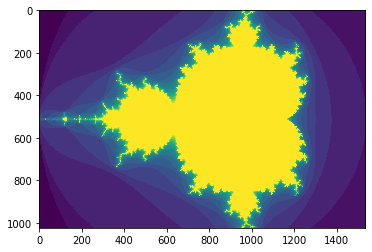

In [8]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = time()
create_fractal_numba(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = time() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

In [9]:
cProfile.run('create_fractal_numba(-2.0, 1.0, -1.0, 1.0, image, 20)')

         4 function calls in 0.057 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.057    0.057    0.057    0.057 <ipython-input-7-c962ae1f6885>:13(create_fractal_numba)
        1    0.000    0.000    0.057    0.057 <string>:1(<module>)
        1    0.000    0.000    0.057    0.057 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [10]:
number_of_iter = [20, 100, 200, 1000, 2000]
image = np.zeros((1024, 1536), dtype = np.uint8)
time_numba = []
for num_iter in tqdm(number_of_iter):
    start = time()
    create_fractal_numba(-2.0, 1.0, -1.0, 1.0, image, num_iter) 
    time_numba.append(time() - start)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


In [11]:
number_of_iter = [20, 100, 200, 1000, 2000]

## Results

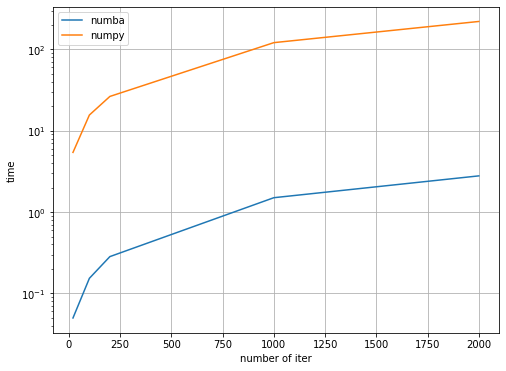

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(number_of_iter, time_numba, label = 'numba')
plt.plot(number_of_iter, time_numpy, label = 'numpy')
plt.yscale('log')
plt.xlabel('number of iter')
plt.ylabel('time')
plt.grid(True)
plt.legend();

# Task 15. N-body problem

In [13]:
from numba import njit
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

## Original

In [14]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    
    def __init__(self, domain=1.0):
        self.x = domain * np.random.random()
        self.y = domain * np.random.random()
        self.z = domain * np.random.random()
        
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [15]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

In [16]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

Now we create a list of `n` random particles, define a function to calculate their interaction via direct summation and run!

In [17]:
np.random.seed(10)

In [30]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]
orig_time = %timeit -o direct_sum(particles)

865 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
cProfile.run('direct_sum(particles)')

         999004 function calls in 0.999 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   999000    0.766    0.000    0.766    0.000 <ipython-input-14-54bfc27b5dd8>:16(distance)
        1    0.233    0.233    0.999    0.999 <ipython-input-16-11a9cd45bce2>:1(direct_sum)
        1    0.000    0.000    0.999    0.999 <string>:1(<module>)
        1    0.000    0.000    0.999    0.999 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




## Jitted

## How do we use Numba on this problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [19]:
particle_dtype = np.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double]})

particle_dtype

dtype([('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [20]:
@njit
def create_n_random_particles(n, m, domain=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = np.zeros((n), dtype=particle_dtype)
    for p in parts:
        p.m = m
        p.phi = 0
        p.x = domain * np.random.random()
        p.y = domain * np.random.random()
        p.y = domain * np.random.random()
    
    return parts   #parts is an array of particles

### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [21]:
@njit
def distance_numba(part1, part2):
    return ((part1['x'] - part2['x'])**2 +
            (part1['y'] - part2['y'])**2 +
            (part1['z'] - part2['z'])**2 )**.5

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [22]:
@njit
def direct_sum_numba(particles):
    for i, target in enumerate(particles):
        for j in range(particles.shape[0]):
            if i == j:
                continue
            source = particles[j]
            r = distance_numba(target, source)
            target.phi += source.m / r

In [32]:
n = 1000
particles_numba = create_n_random_particles(n, 1 / n)
jit_time = %timeit -o direct_sum_numba(particles_numba)

2.45 ms ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
cProfile.run('direct_sum_numba(particles_numba)')

         4 function calls in 0.003 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    0.003    0.003 <ipython-input-22-c052103e35ea>:1(direct_sum_numba)
        1    0.000    0.000    0.003    0.003 <string>:1(<module>)
        1    0.000    0.000    0.003    0.003 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [24]:
sizes = [int(a) for a in np.logspace(2, 3, 10)]

In [25]:
orig_res = []
for size in tqdm(sizes):
    start = datetime.now()
    particles = [Particle(m = 1 / size) for i in range(size)]
    orig_time = %timeit -o direct_sum(particles)
    orig_res.append((datetime.now()-start).total_seconds())

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

10.4 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 10%|████████▎                                                                          | 1/10 [00:08<01:16,  8.53s/it]

17 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


 20%|████████████████▌                                                                  | 2/10 [00:22<01:21, 10.16s/it]

29.3 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 30%|████████████████████████▉                                                          | 3/10 [00:24<00:54,  7.82s/it]

49 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 40%|█████████████████████████████████▏                                                 | 4/10 [00:28<00:40,  6.68s/it]

80.9 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:35<00:33,  6.63s/it]

129 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:45<00:31,  7.78s/it]

241 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:05<00:33, 11.26s/it]

383 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:08<00:17,  8.82s/it]

590 ms ± 79.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:13<00:07,  7.59s/it]

978 ms ± 62.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.08s/it]


In [26]:
jit_res = []
for size in tqdm(sizes):
    start = datetime.now()
    particles_numba = create_n_random_particles(size, 1 / size)
    dsum = direct_sum_numba(particles_numba)
    jit_res.append((datetime.now()-start).total_seconds())

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1212.44it/s]


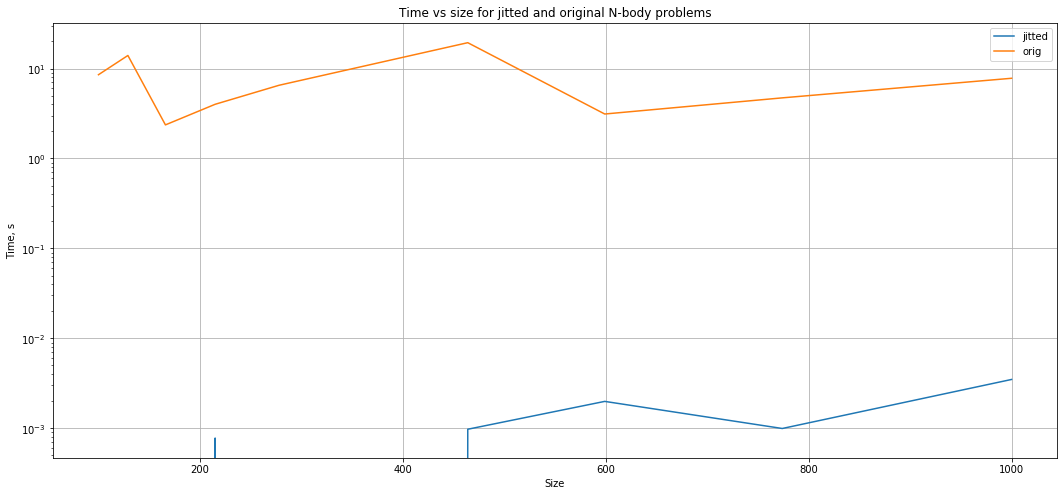

In [27]:
plt.figure(figsize=(18, 8))

plt.plot(sizes, jit_res, label="jitted")
plt.plot(sizes, orig_res, label="orig")
plt.yscale("log")

plt.legend()
plt.grid(True)
plt.title("Time vs size for jitted and original N-body problems")
plt.ylabel("Time, s")
plt.xlabel("Size");